In [27]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------


# Core
import os
import pandas as pd
import geopandas as gpd
import numpy as np

# Spatial
from shapely.geometry import Point
from geopy.distance import geodesic

# Visualisation
import matplotlib.pyplot as plt
import contextily as ctx

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [28]:
# ----------------------------------------------------------
# Step 1 – Define File Paths and Load Processed Inputs
# ----------------------------------------------------------

# Base directory
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")
modality_dir = os.path.join(raw_dir, "modality_modelling")

# Input files
lsoa_gpkg_path = os.path.join(processed_dir, "LSOA_CT_Demand_with_Demographics_2024_v1.gpkg")
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")
cdc_path = os.path.join(modality_dir, "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(modality_dir, "NHS_SW_Acute_Hospitals_Capability.csv")


In [29]:
# Load LSOA demand & demographics
gdf_lsoa = gpd.read_file(lsoa_gpkg_path)

# Load travel matrix (OD: origin-destination pairs with 3 travel modes)
df_travel = pd.read_csv(travel_matrix_path)

# Load site capabilities (CDC + Acute)
df_cdc = pd.read_csv(cdc_path)
df_acute = pd.read_csv(acute_path)


In [30]:
# Basic shapes
print("LSOA data:", gdf_lsoa.shape)
print("Travel matrix:", df_travel.shape)
print("CDC sites:", df_cdc.shape)
print("Acute sites:", df_acute.shape)

# Sample columns
print("\nTravel matrix columns:\n", df_travel.columns.to_list())
print("\nLSOA columns:\n", gdf_lsoa.columns[:10].to_list())
print("\nCDC CT Scanner counts:\n", df_cdc['CT Scanners'].describe())
print("\nAcute CT Scanner counts:\n", df_acute['CT Scanners'].describe())


LSOA data: (3451, 51)
Travel matrix: (11003925, 5)
CDC sites: (24, 22)
Acute sites: (18, 23)

Travel matrix columns:
 ['origin_name', 'destination_name', 'travel_time_car', 'travel_time_pt_peak', 'travel_time_pt_nonpeak']

LSOA columns:
 ['ICB23NM', 'ladnm', 'ladcd', 'msoa21nm', 'msoa21cd', 'lsoa21nmw', 'lsoa21cd', 'total_population', 'age_0_4', 'age_5_9']

CDC CT Scanner counts:
 count    24.000000
mean      0.958333
std       0.806450
min       0.000000
25%       0.750000
50%       1.000000
75%       1.000000
max       3.000000
Name: CT Scanners, dtype: float64

Acute CT Scanner counts:
 count    18.000000
mean      3.055556
std       1.161754
min       1.000000
25%       2.000000
50%       3.000000
75%       3.750000
max       5.000000
Name: CT Scanners, dtype: float64


In [31]:
# ----------------------------------------------------------
# Step 2 – Prepare Site Supply GeoDataFrame (CT Scanner Locations)
# ----------------------------------------------------------

# 2.1 – Filter valid CT-capable sites
df_cdc_valid = df_cdc[df_cdc['CT Scanners'] > 0].copy()
df_acute_valid = df_acute[df_acute['CT Scanners'] > 0].copy()

# 2.2 – Add a site type label
df_cdc_valid['site_type'] = 'CDC'
df_acute_valid['site_type'] = 'Acute'

# 2.3 – Align and concatenate scanner site tables
supply_cols = ['Code', 'Name', 'CT Scanners', 'latitude', 'longitude', 'lsoa21cd', 'site_type']
df_sites = pd.concat([
    df_cdc_valid[supply_cols],
    df_acute_valid[supply_cols]
], ignore_index=True)

# 2.4 – Rename for clarity
df_sites.rename(columns={
    'Code': 'site_id',
    'Name': 'site_name',
    'CT Scanners': 'ct_scanners'
}, inplace=True)

# 2.5 – Convert to GeoDataFrame
gdf_sites = gpd.GeoDataFrame(
    df_sites,
    geometry=gpd.points_from_xy(df_sites['longitude'], df_sites['latitude']),
    crs="EPSG:4326"
)

# 2.6 – Check result
print("Final CT-enabled site supply GeoDataFrame shape:", gdf_sites.shape)
print(gdf_sites[['site_id', 'site_name', 'ct_scanners', 'site_type']].head())


Final CT-enabled site supply GeoDataFrame shape: (36, 8)
  site_id               site_name  ct_scanners site_type
0   B4B4S  Bsw Banes Locality CDC            1       CDC
1   K1W4U           Salisbury CDC            1       CDC
2   O0D8X        West Swindon CDC            1       CDC
3   O1F4J              Weston CDC            1       CDC
4   Q9T4V       North Bristol CDC            1       CDC


In [32]:
# ----------------------------------------------------------
# Step 3 – Calculate Supply-to-Demand Ratio for Each Site
# ----------------------------------------------------------

# 3.1 – Define travel time threshold for catchments (e.g., 30 minutes by car)
CATCHMENT_THRESHOLD = 30  # minutes

# 3.2 – Create working copy of travel matrix (only car mode for now)
df_travel_car = df_travel[df_travel['travel_time_car'] <= CATCHMENT_THRESHOLD].copy()

# 3.3 – Restrict travel matrix to rows where destination is a valid CT site
valid_site_lsoas = gdf_sites['lsoa21cd'].unique()
df_travel_car = df_travel_car[df_travel_car['destination_name'].isin(valid_site_lsoas)]

# 3.4 – Merge with LSOA demand to get ct_total_demand per origin
df_demand = gdf_lsoa[['lsoa21cd', 'ct_total_demand']].copy()
df_demand.rename(columns={'lsoa21cd': 'origin_name'}, inplace=True)
df_travel_car = df_travel_car.merge(df_demand, on='origin_name', how='left')

# 3.5 – Sum demand per destination site (within catchment)
df_demand_sum = df_travel_car.groupby('destination_name')['ct_total_demand'].sum().reset_index()
df_demand_sum.rename(columns={'ct_total_demand': 'total_catchment_demand'}, inplace=True)

# 3.6 – Merge demand totals into site table
gdf_sites = gdf_sites.merge(df_demand_sum, left_on='lsoa21cd', right_on='destination_name', how='left')

# 3.7 – Compute supply-to-demand ratio
gdf_sites['supply_demand_ratio'] = gdf_sites['ct_scanners'] / gdf_sites['total_catchment_demand']

# 3.8 – Fill any NaNs (e.g. sites with no catchment demand) with 0
gdf_sites['supply_demand_ratio'] = gdf_sites['supply_demand_ratio'].fillna(0)

# 3.9 – Inspect results
print("Supply-to-demand ratio stats:\n", gdf_sites['supply_demand_ratio'].describe())
print("\nExample sites:\n", gdf_sites[['site_name', 'site_type', 'ct_scanners', 'total_catchment_demand', 'supply_demand_ratio']].head())


Supply-to-demand ratio stats:
 count    36.000000
mean      0.000055
std       0.000044
min       0.000000
25%       0.000025
50%       0.000049
75%       0.000084
max       0.000157
Name: supply_demand_ratio, dtype: float64

Example sites:
                 site_name site_type  ct_scanners  total_catchment_demand  \
0  Bsw Banes Locality CDC       CDC            1            34137.418991   
1           Salisbury CDC       CDC            1            15204.026188   
2        West Swindon CDC       CDC            1            36522.887765   
3              Weston CDC       CDC            1            25428.484414   
4       North Bristol CDC       CDC            1            77881.441976   

   supply_demand_ratio  
0             0.000029  
1             0.000066  
2             0.000027  
3             0.000039  
4             0.000013  


In [33]:
# ----------------------------------------------------------
# Step 4 – Calculate Accessibility Scores for All Travel Modes (Robust)
# ----------------------------------------------------------

# Define travel modes and threshold
travel_modes = {
    'car': 'travel_time_car',
    'pt_peak': 'travel_time_pt_peak',
    'pt_nonpeak': 'travel_time_pt_nonpeak'
}

CATCHMENT_THRESHOLD = 30  # minutes

# Loop over each mode
for mode_label, mode_col in travel_modes.items():
    
    print(f"\n▶ Calculating accessibility score for: {mode_label} (≤{CATCHMENT_THRESHOLD} min)")

    # 4.1 – Filter travel matrix to those within threshold
    df_mode = df_travel[df_travel[mode_col] <= CATCHMENT_THRESHOLD].copy()
    
    # 4.2 – Restrict to destinations with valid CT scanner sites
    df_mode = df_mode[df_mode['destination_name'].isin(gdf_sites['lsoa21cd'])]
    
    # 4.3 – Attach supply-to-demand ratios
    df_ratios = gdf_sites[['lsoa21cd', 'supply_demand_ratio']].copy()
    df_ratios.rename(columns={'lsoa21cd': 'destination_name'}, inplace=True)
    df_mode = df_mode.merge(df_ratios, on='destination_name', how='left')
    
    # 4.4 – Group by origin and sum accessible ratios
    df_accessibility = df_mode.groupby('origin_name')['supply_demand_ratio'].sum().reset_index()
    df_accessibility.rename(columns={
        'origin_name': 'lsoa21cd',
        'supply_demand_ratio': f'accessibility_score_{mode_label}'
    }, inplace=True)
    
    print(f"→ LSOAs with non-zero access for {mode_label}: {df_accessibility.shape[0]}")
    
    # 4.5 – Merge score into LSOA GeoDataFrame
    merge_col = f'accessibility_score_{mode_label}'
    gdf_lsoa = gdf_lsoa.merge(df_accessibility, on='lsoa21cd', how='left')

    # 4.6 – Safely fill missing values (no access)
    if merge_col not in gdf_lsoa.columns:
        print(f"Warning: '{merge_col}' missing after merge. Filling with 0.")
        gdf_lsoa[merge_col] = 0
    else:
        gdf_lsoa[merge_col] = gdf_lsoa[merge_col].fillna(0)



▶ Calculating accessibility score for: car (≤30 min)
→ LSOAs with non-zero access for car: 2777

▶ Calculating accessibility score for: pt_peak (≤30 min)
→ LSOAs with non-zero access for pt_peak: 1134

▶ Calculating accessibility score for: pt_nonpeak (≤30 min)
→ LSOAs with non-zero access for pt_nonpeak: 1111


In [34]:
# ----------------------------------------------------------
# Step 5 – Normalise Accessibility Scores (0–1 scale)
# ----------------------------------------------------------

# Ensure travel_modes dict exists
travel_modes = {
    'car': 'travel_time_car',
    'pt_peak': 'travel_time_pt_peak',
    'pt_nonpeak': 'travel_time_pt_nonpeak'
}

# Normalise scores for each mode using min-max scaling
for mode in travel_modes:
    col = f'accessibility_score_{mode}'
    norm_col = f'{col}_norm'
    
    if col in gdf_lsoa.columns:
        col_min = gdf_lsoa[col].min()
        col_max = gdf_lsoa[col].max()
        if col_max > col_min:
            gdf_lsoa[norm_col] = (gdf_lsoa[col] - col_min) / (col_max - col_min)
        else:
            gdf_lsoa[norm_col] = 0  # All values are identical
    else:
        gdf_lsoa[norm_col] = 0  # Column does not exist

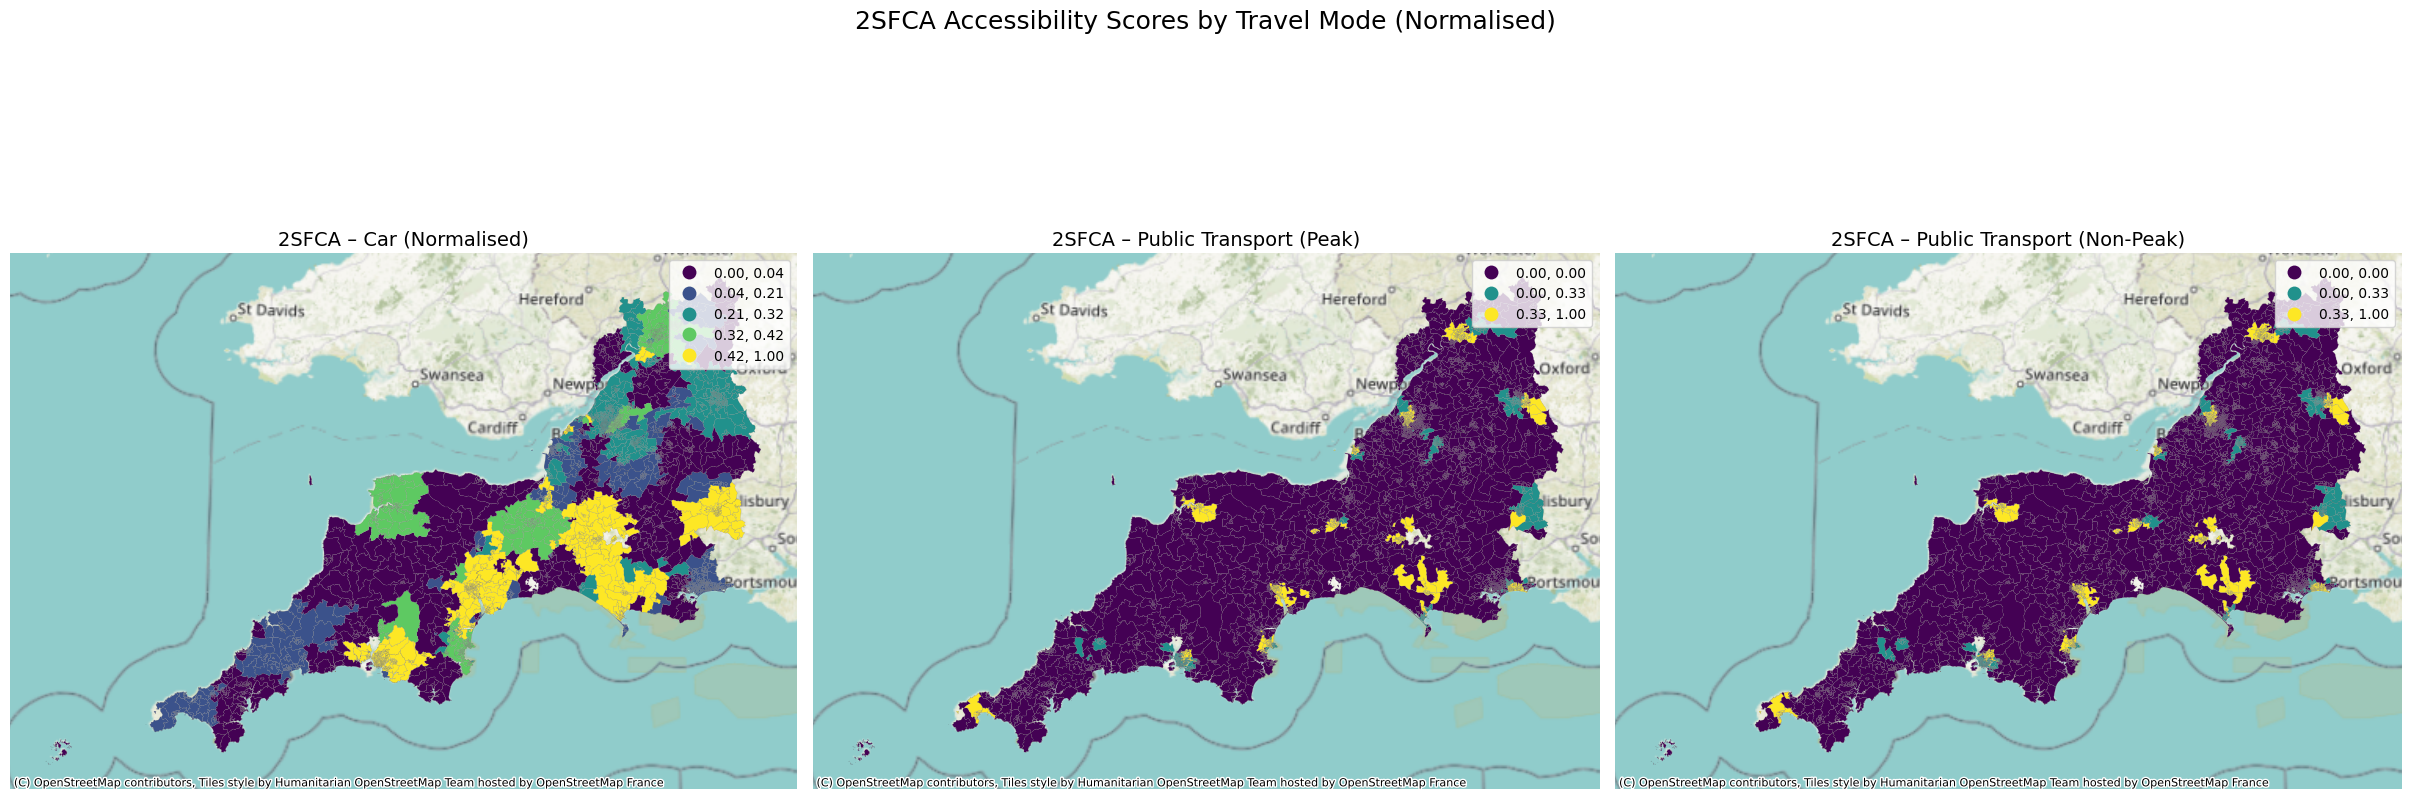

In [35]:
# ----------------------------------------------------------
# Step 6 – Generate 3-Panel Choropleth of Normalised Scores
# ----------------------------------------------------------

# Define columns and titles
score_columns = [
    'accessibility_score_car_norm',
    'accessibility_score_pt_peak_norm',
    'accessibility_score_pt_nonpeak_norm'
]

titles = [
    '2SFCA – Car (Normalised)',
    '2SFCA – Public Transport (Peak)',
    '2SFCA – Public Transport (Non-Peak)'
]

# Create side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(24, 10), constrained_layout=True)

for i, (col, title) in enumerate(zip(score_columns, titles)):
    gdf_lsoa.plot(
        column=col,
        cmap='viridis',
        scheme='quantiles',
        k=5,
        linewidth=0.1,
        edgecolor='grey',
        legend=True,
        ax=axes[i]
    )
    ctx.add_basemap(axes[i], crs=gdf_lsoa.crs.to_string())
    axes[i].set_title(title, fontsize=14)
    axes[i].axis("off")

plt.suptitle("2SFCA Accessibility Scores by Travel Mode (Normalised)", fontsize=18)
plt.show()

In [17]:
# ----------------------------------------------------------
# Final Step  – Export Results for Scenario Modelling
# ----------------------------------------------------------


# Define export paths
output_dir = os.path.join(base_dir, "data", "processed")

lsoa_gpkg_path = os.path.join(output_dir, "LSOA_CT_2SFCA_Accessibility_2024.gpkg")
sites_gpkg_path = os.path.join(output_dir, "CT_Scanner_Sites_With_SupplyRatios.gpkg")
summary_csv_path = os.path.join(output_dir, "LSOA_2SFCA_Accessibility_Summary_2024.csv")
map_png_path = os.path.join(output_dir, "2SFCA_3Mode_Comparison.png")

# 1. Export full LSOA GeoDataFrame with access scores
gdf_lsoa.to_file(lsoa_gpkg_path, driver="GPKG")

# 2. Export scanner sites (CDC + Acute) with supply ratios
gdf_sites.to_file(sites_gpkg_path, driver="GPKG")

# 3. Export a summary CSV (non-spatial, for inspection or Excel)
summary_cols = ['lsoa21cd', 'total_population',
                'accessibility_score_car', 'accessibility_score_pt_peak', 'accessibility_score_pt_nonpeak',
                'accessibility_score_car_norm', 'accessibility_score_pt_peak_norm', 'accessibility_score_pt_nonpeak_norm']
gdf_lsoa[summary_cols].to_csv(summary_csv_path, index=False)

# 4. Export final 3-panel map (if figure object still exists)
try:
    fig.savefig(map_png_path, dpi=300)
    print("3-panel accessibility map saved.")
except NameError:
    print("No active figure to save. Skipped PNG export.")

print("All baseline outputs exported successfully.")


3-panel accessibility map saved.
All baseline outputs exported successfully.
